# NLP Project: Suicide Post Detection

### About the dataset:

The dataset we are using for this project can be found at https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch

Mental Health is a very popular topic for study as technology becomes more and more advanced. Especially post Covid-19 pandemic where everyone was forced to quarantine, the study of depression and suicide ideation has become even more important. The purpose of this project is to build a classifier that is able to accurately detect whether or not a post has suicide ideations so that resources may be provided to the user to help them through their struggles. For now, this project will focus primarily on building the classification model.

The dataset from kaggle consists of over 200k posts from the popular forum Reddit.com along with another column with the label(s): <b>Suicide</b> or <b>Non-Suicide</b>. We will analyze these posts using NLP processes and build a model that will predict if the post is labeled Suicide or Non-Suicide. Afterwards, we will fine-tune a transformer in an attempt to achieve greater results than the original model we built. 

In [1]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the necessary packages

In [3]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import FreqDist
from gensim.utils import tokenize
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
import os
import numpy as np
from scipy.stats import randint
import seaborn as sns 
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from yellowbrick.text import TSNEVisualizer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.text import FreqDistVisualizer
#nltk.download()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# you might need to restart the runtime after this line
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


## Load the Dataset from Google Drive

In [5]:
import gdown
# download recipe data set
gdrivelink='https://drive.google.com/uc?id=1_cOyPN6zbV9Cr3Uwqfjf8X2oUvEO_G8o'
gdown.download(gdrivelink, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_cOyPN6zbV9Cr3Uwqfjf8X2oUvEO_G8o
To: /content/Suicide_Detection.csv
100%|██████████| 167M/167M [00:03<00:00, 54.0MB/s]


'Suicide_Detection.csv'

In [6]:
# Data
import pandas as pd
posts = pd.read_csv('Suicide_Detection.csv',encoding='latin1',index_col=0)
#posts = pd.read_csv("/content/sample_data/Suicide_Detection.csv",encoding='latin1',index_col=0)
posts.head(5)

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"Iâm so lostHello, my name is Adam (16) and I...",suicide


In [7]:
# We are only using half the dataset due to how long it takes to run the code
posts=posts.sample(frac =.50,random_state=0)

In [8]:
# Drop the null/ NaN values in the dataset
posts.dropna(how="any", inplace=True, axis=1)

In [9]:
# we concatenated all text
text = posts.text.str.cat(sep=' ')
text[:1000]

'Saying stuff Iâ\x80\x99ve never said before I dieDonâ\x80\x99t read this if youâ\x80\x99re here to help me. I donâ\x80\x99t want help. I donâ\x80\x99t want advice or kind words. I just want to be able to vent and say stuff I never got the chance to before I die. So please just help someone else. Thank you.\n\nHow the fuck am I still alive? I didnâ\x80\x99t think Iâ\x80\x99d make it past 12. Somehow, against every single odd, Iâ\x80\x99m finally an adult. I barely made it through my last year of high school. How am I still here?\n\nIâ\x80\x99ve been taking antidepressants on and off for a year now. I just get too depressed to take them, like why do I deserve them? What did I ever do to be able to deserve happiness? I didnâ\x80\x99t do anything good, so why should I be rewarded with it. I finally was able to take them for a few solid weeks in a row now, and then they suddenly just stopped. Iâ\x80\x99m fucking depressed as hell now and I relapsed and cut myself for the first time in mont

In [10]:
# Defining a clean text function to tokenize text, remove stopworks, remove irrelvant words
# (words whose length is less than 2 and more than 15) and tranform words into their root form using lemmatizer. 
# Our output is in the form of a list

stop_words = set(stopwords.words('english'))
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = list(tokenize(text))
    #res = ' '.join([stemmer.stem(t.lower()) for t in tokens if t.lower() not in stop_words]) 
    #res = ' '.join([lemmatizer.lemmatize(t.lower()) for t in tokens if t.lower() not in stop_words])
    res = [lemmatizer.lemmatize(t.lower()) for t in tokens if t.lower() not in stop_words and 2<len(t) and len(t)<15]
    if len(res) == 0:
        return ' '
    else:
        return res

In [11]:
clean_text(text)[:20]

['saying',
 'stuff',
 'never',
 'said',
 'diedonâ',
 'read',
 'youâ',
 'help',
 'donâ',
 'want',
 'help',
 'donâ',
 'want',
 'advice',
 'kind',
 'word',
 'want',
 'able',
 'vent',
 'say']

### Text Exploration through Word Cloud.
#### We are going to vizualize the words that are most frequently used in the whole text and then the text labeled suicide and non-suicide separately

In [12]:
#define a function for wordcloud
def make_word_cloud(words):
    wordc = WordCloud(width=1600, height=800, background_color="white").generate_from_frequencies(FreqDist(words))
    # Open a plot of the generated image.

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordc)
    plt.axis("off")

    # save
    #plt.savefig('wordcloud.png',dpi=600, facecolor='k', bbox_inches='tight')
    plt.tight_layout(pad=0)

    # show
    plt.show()

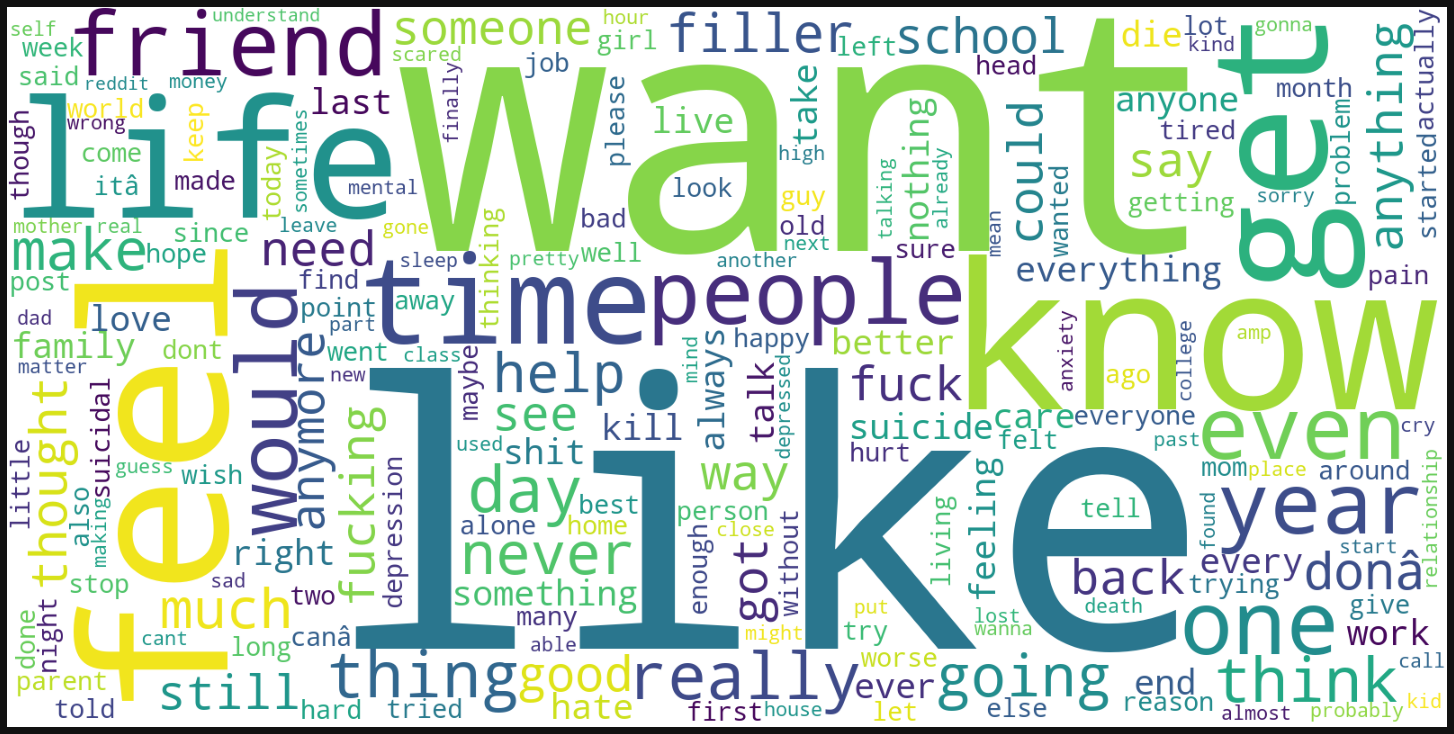

In [13]:
# word_cloud of the complete text
make_word_cloud(clean_text(text))

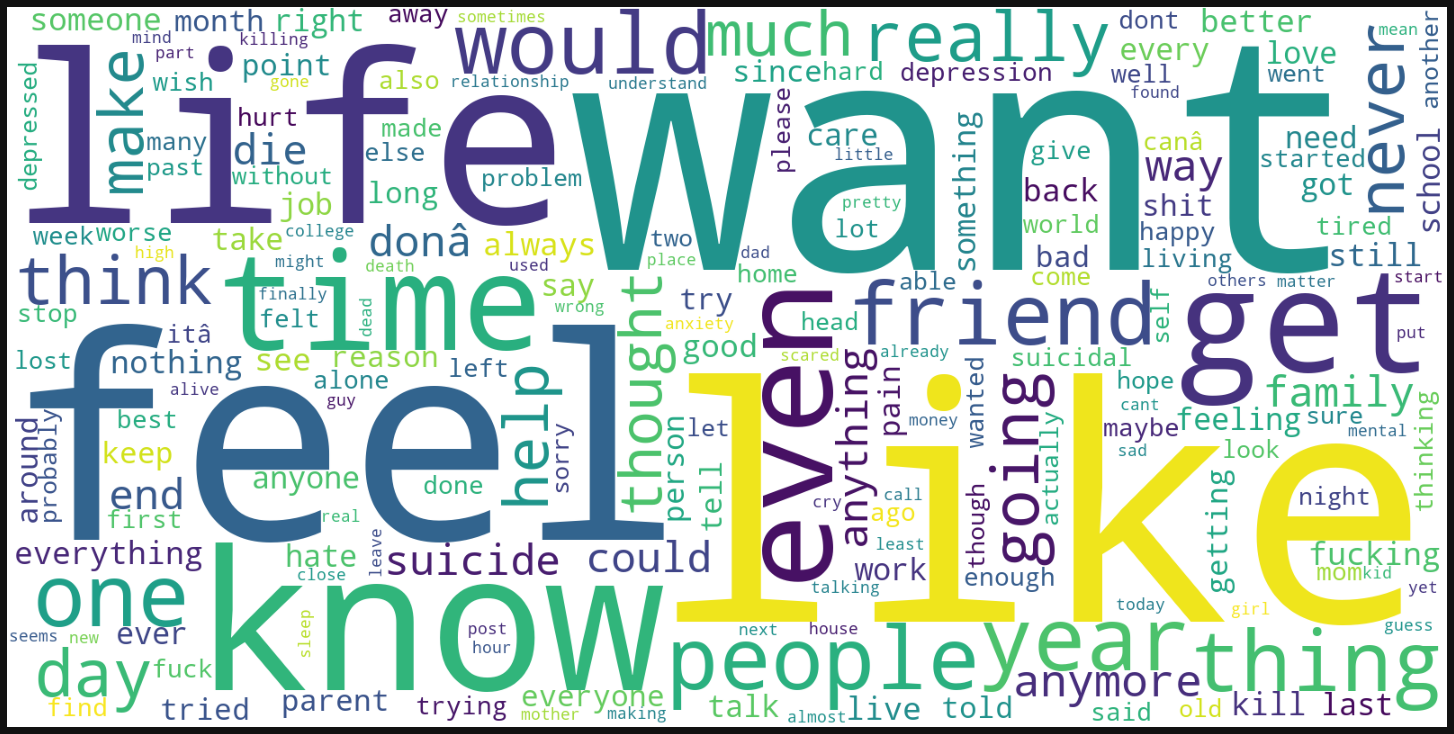

In [14]:
# word_cloud for text in class suicide
posts_Suicidal = posts[posts["class"]== "suicide"]
text_Suicidal = posts_Suicidal["text"].str.cat(sep=' ').lower()
make_word_cloud(clean_text(text_Suicidal))
#posts_Suicidal.head()

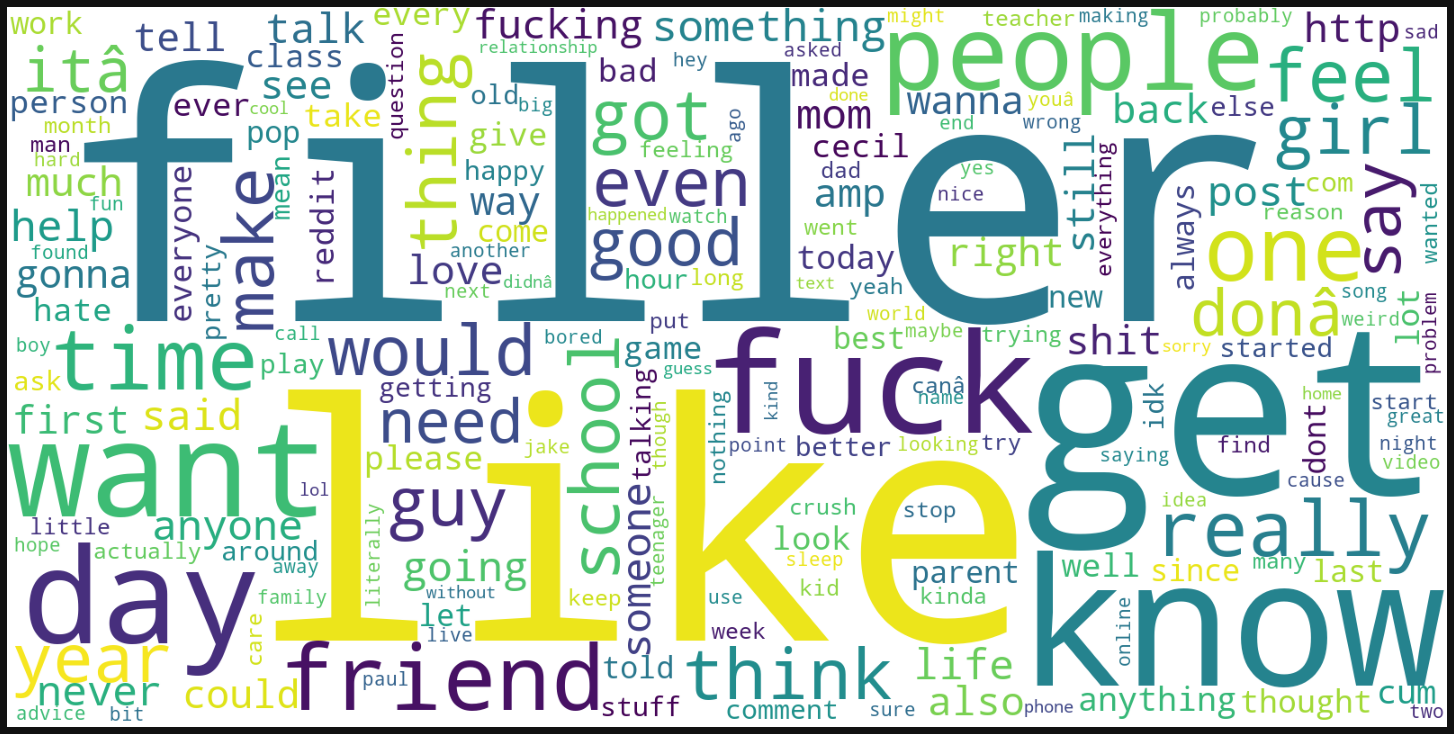

In [15]:
# word_cloud for text in class non-suicide
posts_non_Suicidal = posts[posts["class"]== "non-suicide"]
text_non_Suicidal = posts_non_Suicidal.text.str.cat(sep=' ').lower()
make_word_cloud(clean_text(text_non_Suicidal))

There are a lot of overlapping words between suicidal and non-suicidal posts in the word clouds. We elected to keep some of the stop words in the dataset because of it's usefulness when calculating bigram frequency distribution later on.

In [16]:
from collections import Counter
counter1 = Counter(clean_text(text))
counter1.most_common(10)

[('like', 93044),
 ('want', 79065),
 ('know', 69735),
 ('feel', 68473),
 ('life', 64781),
 ('get', 61421),
 ('time', 53128),
 ('people', 47674),
 ('one', 47524),
 ('friend', 46151)]

These are the most frequent words overall.

In [17]:
counter_Suicidal = Counter(clean_text(text_Suicidal))
counter_Suicidal.most_common(10)

[('want', 67459),
 ('like', 66537),
 ('feel', 60181),
 ('life', 59468),
 ('know', 56486),
 ('get', 47694),
 ('time', 43116),
 ('even', 38601),
 ('year', 37653),
 ('one', 36622)]

The most frequent words for posts with the class = 'Suicide'.

In [18]:
counter_non_Suicidal = Counter(clean_text(text_non_Suicidal))
counter_non_Suicidal.most_common(10)

[('filler', 28321),
 ('like', 26507),
 ('get', 13727),
 ('know', 13249),
 ('fuck', 12381),
 ('want', 11606),
 ('day', 11377),
 ('people', 11213),
 ('friend', 10971),
 ('one', 10902)]

The most frequent words for posts with the class = 'Non-Suicide'.

## Count Vectorizer & TF-IDF Vectorizer 

In [19]:
# identifying our documents(X) and labels(Y)
documents= posts.text
labels = posts["class"]

In [20]:
# We have defined a new function for clean_text which is a string and not a list. Everything else is the same
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = list(tokenize(text))
    #res = ' '.join([stemmer.stem(t.lower()) for t in tokens if t.lower() not in stop_words]) 
    res = ' '.join([lemmatizer.lemmatize(t.lower()) for t in tokens if t.lower() not in stop_words and 2<len(t) and len(t)<15]) 
    if len(res) == 0:
        return ' '
    else:
        return res 

In [21]:
#Make document-term Matrix using Tfidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=clean_text,ngram_range=(2,2))
res = tfidf.fit_transform(documents)
res


<116037x2214425 sparse matrix of type '<class 'numpy.float64'>'
	with 6552899 stored elements in Compressed Sparse Row format>

In [22]:
#Make document-term Matrix using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer(preprocessor=clean_text,ngram_range=(2,2)) 
res2 = count_vect.fit_transform(documents)
res2

<116037x2214425 sparse matrix of type '<class 'numpy.int64'>'
	with 6552899 stored elements in Compressed Sparse Row format>

In [23]:
# get the features for both
features = tfidf.get_feature_names_out()
features2 = count_vect.get_feature_names_out()

#### Frequency Distribution of top 10 bigram tokens

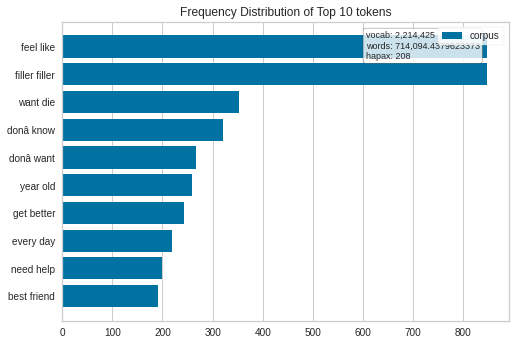

In [24]:
#with TFIDF
visualizer = FreqDistVisualizer(features=features,n=10)
visualizer.fit(res)
visualizer.show()

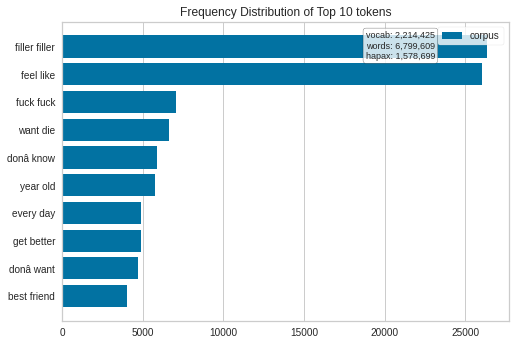

In [25]:
#with CountVectorizer
visualizer2 = FreqDistVisualizer(features=features2,n=10)
visualizer2.fit(res2)
visualizer2.show()

In the above figures we see some of the words that are most frequently used in the texts like 'need help', 'want die' 

#### Terms with largest average tfidf value. 

In [26]:
vals = res.sum(axis=0) / res.getnnz(axis=0)
vals.shape

(1, 2214425)

In [27]:
indices = vals.argsort()
indices

matrix([[ 298008, 2161463, 1186159, ...,  854171, 1468979,  797385]])

In [28]:
for i in range(1,20):
    ind = indices[0,-i]
    print(f'feature {features[ind]}: value = {vals[0,ind]}')

feature giggity giggity: value = 1.0
feature popular award: value = 1.0
feature guy hiiiiii: value = 1.0
feature gallows ghetto: value = 1.0
feature suck bowling: value = 1.0
feature pleasethinking ending: value = 1.0
feature honest requirement: value = 1.0
feature killing myselfbye: value = 1.0
feature talk someonehey: value = 1.0
feature horni donâ: value = 1.0
feature pickle cucumber: value = 1.0
feature spaghetti sauce: value = 1.0
feature fuck dudefuck: value = 1.0
feature long exercise: value = 1.0
feature imposter susð: value = 1.0
feature ben hello: value = 1.0
feature unpopular onion: value = 1.0
feature doneno meaning: value = 1.0
feature frog pog: value = 1.0


Terms with largest TFIDF do not give us any useful information

## Topics Analysis

Using the clean_text function defined above to preprocess the dataset, we employ LDiA to detect five topics and show the top five terms for each topic. 

In [29]:
#Make document-term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer(preprocessor=clean_text) # only unigrams
td = count_vect.fit_transform(documents)

In [30]:
td.shape

(116037, 95500)

In [31]:
#Document-Topic Matrix
from sklearn.decomposition import LatentDirichletAllocation
ntopics = 5
lda = LatentDirichletAllocation(n_components=ntopics,random_state=0)
doc_topic = lda.fit_transform(td)

In [32]:
doc_topic.shape

(116037, 5)

In [33]:
doc_topic

array([[5.68505895e-04, 1.58972284e-01, 3.27736078e-01, 5.62160376e-04,
        5.12160972e-01],
       [1.18713761e-02, 9.51858182e-01, 1.20872343e-02, 1.19838842e-02,
        1.21993237e-02],
       [4.79959377e-01, 1.72112819e-02, 3.16989616e-01, 1.68909438e-01,
        1.69302869e-02],
       ...,
       [1.00407147e-02, 1.00652119e-02, 3.99682575e-01, 1.00810842e-02,
        5.70130414e-01],
       [1.82582293e-02, 1.88904956e-02, 1.88808415e-02, 1.90881282e-02,
        9.24882306e-01],
       [9.99678745e-04, 2.42441353e-01, 3.48325634e-01, 3.53495261e-02,
        3.72883808e-01]])

In [34]:
#Topic-term matrix
lda.components_.shape

(5, 95500)

In [35]:
lda.components_.sum(axis=1)

array([ 342522.5029249 , 1373269.88574417, 3313488.42850452,
        379268.59791615, 1602529.58480667])

In [36]:
lda.components_.sum(axis=1).reshape((ntopics,1))

array([[ 342522.5029249 ],
       [1373269.88574417],
       [3313488.42850452],
       [ 379268.59791615],
       [1602529.58480667]])

In [37]:
topic_term = lda.components_ / lda.components_.sum(axis=1).reshape((ntopics,1))

In [38]:
topic_term.shape

(5, 95500)

In [39]:
topic_term

array([[8.07017616e-06, 3.30790474e-05, 2.91258953e-05, ...,
        3.49692833e-06, 5.83962806e-07, 6.42293530e-06],
       [1.19242577e-05, 5.65312246e-06, 6.06166556e-06, ...,
        1.45639422e-07, 8.73794291e-07, 1.45637812e-07],
       [1.26235629e-06, 1.68308319e-06, 2.80517498e-06, ...,
        6.03596132e-08, 6.03599686e-08, 6.03593502e-08],
       [2.13110272e-05, 5.34306920e-07, 5.34803526e-07, ...,
        5.33179883e-07, 5.27375203e-07, 5.27330966e-07],
       [3.71383278e-07, 1.32721202e-06, 1.25847078e-07, ...,
        1.24803847e-07, 1.24805996e-07, 1.24802700e-07]])

In [40]:
# Topic Description
features = count_vect.get_feature_names_out()
len(features)

95500

In [41]:
term_topics = pd.DataFrame(index=features,data= topic_term.T)
term_topics

,0,1,2,3,4
___,8.070176e-06,1.192426e-05,1.262356e-06,2.131103e-05,3.713833e-07
____,3.307905e-05,5.653122e-06,1.683083e-06,5.343069e-07,1.327212e-06
_____,2.912590e-05,6.061666e-06,2.805175e-06,5.348035e-07,1.258471e-07
______,1.740119e-05,1.461377e-07,1.941464e-06,5.347654e-07,1.267853e-07
_______,6.188218e-07,2.863076e-07,7.049664e-08,5.329236e-07,2.056695e-05
...,...,...,...,...,...
ø¹ù,8.816836e-05,1.456378e-07,6.035936e-08,5.282584e-07,1.248027e-07
øºø,6.421894e-06,1.456379e-07,6.035936e-08,5.282713e-07,1.248027e-07
øºù,3.496928e-06,1.456394e-07,6.035961e-08,5.331799e-07,1.248038e-07
ù¹à¼,5.839628e-07,8.737943e-07,6.035997e-08,5.273752e-07,1.248060e-07


In [42]:
for i in range(ntopics):
    print(f'=== TOPIC {i} ===')
    print(term_topics[i].sort_values(ascending=False).head(5))

=== TOPIC 0 ===
filler    0.082713
fuck      0.042509
like      0.013544
post      0.013177
wanna     0.009558
Name: 0, dtype: float64
=== TOPIC 1 ===
like      0.013861
day       0.011411
school    0.010330
friend    0.010311
got       0.009731
Name: 1, dtype: float64
=== TOPIC 2 ===
life      0.013607
like      0.011499
feel      0.010329
know      0.009920
people    0.009547
Name: 2, dtype: float64
=== TOPIC 3 ===
amp     0.022189
get     0.014626
http    0.013991
com     0.009318
mom     0.009248
Name: 3, dtype: float64
=== TOPIC 4 ===
want    0.026838
feel    0.020345
like    0.018061
know    0.016644
donâ    0.015307
Name: 4, dtype: float64


In [43]:
posts['topic'] = doc_topic.argmax(axis=1)
posts

,text,class,topic
151664,Saying stuff Iâve never said before I dieDon...,suicide,4
237851,I was almost hit by a car on the way home toda...,suicide,1
232457,Fun reddit fact When you search in the term â...,non-suicide,0
339822,please help me settle an argument: which is be...,non-suicide,3
122908,28/f - I really need some open minded female f...,suicide,2
...,...,...,...
338194,My rats are all that's keeping me goingI broug...,suicide,1
203531,Cheating on math test So my phone has a 2 minu...,non-suicide,1
202462,My only anchor to this worldIs that if I do go...,suicide,4
175052,I think I fucked upI only took about 200mg of ...,suicide,4


In [44]:
posts_suicide=posts.groupby(['class','topic']).size().unstack('class')
posts_suicide

class,non-suicide,suicide
topic,,
0,13367,372
1,21207,3548
2,7417,28329
3,8495,585
4,7618,25099


In [45]:
posts_suicide["suicide_proportion"]= posts_suicide["suicide"] / (posts_suicide["non-suicide"] + posts_suicide["suicide"])

In [46]:
posts_suicide["non_suicide_proportion"]= posts_suicide["non-suicide"] / (posts_suicide["non-suicide"] + posts_suicide["suicide"])

#### We divided all the texts into 5 topics to see if a particular topic is more closely related to suicide or not.

In [47]:
posts_suicide

class,non-suicide,suicide,suicide_proportion,non_suicide_proportion
topic,,,,
0,13367,372,0.027076,0.972924
1,21207,3548,0.143325,0.856675
2,7417,28329,0.792508,0.207492
3,8495,585,0.064427,0.935573
4,7618,25099,0.767155,0.232845


As we can see, most of the suicidal posts fall in topic 2 and topic 4 which are heavy on words like: life,like,feel, people,want,feel,like,know,donâ.

# Classification

In [48]:
posts.head(10)

,text,class,topic
151664,Saying stuff Iâve never said before I dieDon...,suicide,4
237851,I was almost hit by a car on the way home toda...,suicide,1
232457,Fun reddit fact When you search in the term â...,non-suicide,0
339822,please help me settle an argument: which is be...,non-suicide,3
122908,28/f - I really need some open minded female f...,suicide,2
336193,"I have mental health issues, want to dieHi!\n\...",suicide,2
172165,Ight Iâm gonna be real with yâall I donâ...,non-suicide,4
38494,"Is it possible for everyone to get ripped, or ...",non-suicide,1
105932,I have no support system in my life.Telling me...,suicide,2
263352,I thought i would be dead before I hit 16 But ...,non-suicide,2


In [49]:
posts["class"].unique()

array(['suicide', 'non-suicide'], dtype=object)

#### Both classes look balanced

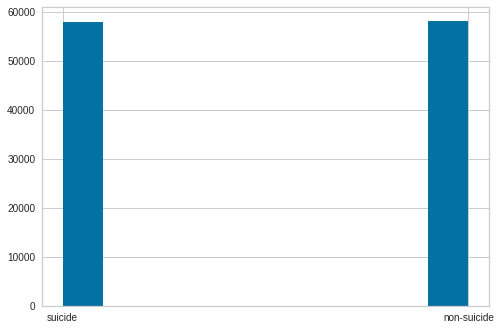

In [50]:
import matplotlib.pyplot as plt
plt.hist(labels)
plt.show() 

## Train-test splits

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(documents, labels, random_state=1, test_size = 0.3)

In [52]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(81225,) (34812,) (81225,) (34812,)


In [53]:
X_train

117657    My heart hurts so much. (Both 18M and 18F) He ...
247274    Wait and seeToday I had a job interview, the f...
208993    Will someone please talk to me?Iâm crying ri...
271706      Is anyone looking to get dominated Because same
69073     Goodbye and good luckLong story short , got my...
                                ...                        
157607    Do samaritans help?I want to call samaritans b...
291581    Shoutout to my mom She finally learned how to ...
203671    It's never quietI'm an emotional cripple too p...
282524    Reasons why yâall are unique and important 1...
229469    ya boi is stressed and depressed iâm about t...
Name: text, Length: 81225, dtype: object

In [54]:
y_train

117657    non-suicide
247274        suicide
208993        suicide
271706    non-suicide
69073         suicide
             ...     
157607        suicide
291581    non-suicide
203671        suicide
282524    non-suicide
229469    non-suicide
Name: class, Length: 81225, dtype: object

## Make Document-Term Matrices

### Train-Test Split, Count Vectorizer, and Logistic Regression

In [55]:
# Build Vectorizer
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer(preprocessor=clean_text, ngram_range=(1,2)) 
count_vect.fit(X_train) 

### Build Document-Term matrices
X_train_mat = count_vect.transform(X_train)
X_test_mat = count_vect.transform(X_test)

## Train with Logistic Regression

from sklearn.naive_bayes import MultinomialNB
cl = LogisticRegression()
cl.fit(X_train_mat,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Interpret coefficients

### Which words are more associated with suicide vs not-suicide

In [56]:
cl.coef_[0]

array([-2.74488904e-01, -8.12806363e-02,  5.96037028e-05, ...,
       -1.26015579e-03, -8.40049603e-03, -8.40049603e-03])

In [57]:
cl.coef_.max()

3.1128071790908556

In [58]:
cl.coef_.min()

-2.0510056968586228

In [59]:
cl.coef_[0].argmax()

1503067

In [60]:
cl.coef_[0].argmin()

338760

In [61]:
features = count_vect.get_feature_names_out()

In [62]:
# term is most strongly associated with a "suicide" prediction
features[cl.coef_[0].argmax()]

'suicidal'

In [63]:
#term is most strongly associated with a "non suicide" prediction
features[cl.coef_[0].argmin()]

'crush'

In [64]:
import numpy as np
ind = np.abs(cl.coef_[0]).argsort()

In [65]:
# To cross check the answer
for i in range(15):
    index = ind[-1-i]
    print(f'{i}: {cl.coef_[0][index]} --> {features[index]}')

0: 3.1128071790908556 --> suicidal
1: 3.0893572847626087 --> suicide
2: 2.664507933711831 --> helpi
3: 2.5537576152270094 --> mei
4: 2.3105199372155254 --> killing
5: 2.3034122278384155 --> iti
6: 2.2443410370208197 --> overdose
7: 2.232223254642341 --> myselfi
8: 2.1406137631384823 --> diei
9: 2.129996771033749 --> kill
10: 2.1205959231755815 --> pill
11: 2.0959366659992362 --> anymorei
12: -2.0510056968586228 --> crush
13: -1.9582678156117055 --> bruh
14: -1.9000519598803385 --> horny


We can clearly see the words like suicidal,helpi,killing and overdose strongly assciated with suicide.

## Predict

In [66]:
#with CountVectorizer
y_pred = cl.predict(X_test_mat)
y_pred

array(['suicide', 'non-suicide', 'non-suicide', ..., 'suicide',
       'non-suicide', 'suicide'], dtype=object)

In [67]:
#with CountVectorizer
cl.predict_proba(X_test_mat)

array([[4.36323446e-05, 9.99956368e-01],
       [9.99702952e-01, 2.97048265e-04],
       [9.89515696e-01, 1.04843035e-02],
       ...,
       [5.86768113e-08, 9.99999941e-01],
       [9.91862347e-01, 8.13765296e-03],
       [3.61282574e-01, 6.38717426e-01]])

## Analyze Performance with CountVectorizer

In [68]:
#with CountVectorizer
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.93     17398
     suicide       0.95      0.91      0.93     17414

    accuracy                           0.93     34812
   macro avg       0.93      0.93      0.93     34812
weighted avg       0.93      0.93      0.93     34812



Our Logistic Regression performance using CountVectorizer has an accuracy of 93%

### Build TF-IDF Vectorizer and Logistic Regression

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=clean_text,ngram_range=(1,2))
tfidf.fit(X_train)


### Build Document-Term matrices
X_train_mat = tfidf.transform(X_train)
X_test_mat = tfidf.transform(X_test)

## Train with Logistic Regression


cl2 = LogisticRegression()
cl2.fit(X_train_mat,y_train)

LogisticRegression()

In [70]:
#with TFIDF
y_pred = cl2.predict(X_test_mat)
y_pred

array(['suicide', 'non-suicide', 'non-suicide', ..., 'suicide',
       'non-suicide', 'suicide'], dtype=object)

In [71]:
#with TFIDF
cl2.predict_proba(X_test_mat)

array([[0.01086663, 0.98913337],
       [0.98644919, 0.01355081],
       [0.95813092, 0.04186908],
       ...,
       [0.01299564, 0.98700436],
       [0.80730849, 0.19269151],
       [0.49739994, 0.50260006]])

## Analyze Performance with TF-IDF Vectorizer

In [72]:
#with TFIDF
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 non-suicide       0.93      0.93      0.93     17398
     suicide       0.93      0.94      0.93     17414

    accuracy                           0.93     34812
   macro avg       0.93      0.93      0.93     34812
weighted avg       0.93      0.93      0.93     34812



Our Logistic Regression performance using TF-IDF Vectorizer is also an accuracy of 93%

## GridSearchCV using Random Forest Classifier

In [73]:
#Random Forest Classifier
pipeRF = make_pipeline( RandomForestClassifier(random_state=0))

param_gridRF= {'randomforestclassifier__max_features': [2,4,6,8,10],
              'randomforestclassifier__max_depth': [6,8,10,12,14]}

gridRF = GridSearchCV(pipeRF, param_grid=param_gridRF, cv=5, return_train_score=True)
gridRF.fit(X_train_mat , y_train)

accuracyRF = gridRF.score(X_test_mat, y_test)

print('AccuracyRF score of the {} is {:.2f}'.format(gridRF.__class__.__name__, accuracyRF))
print(f"best parameters: {gridRF.best_params_}")


AccuracyRF score of the GridSearchCV is 0.65
best parameters: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 10}


Our Random Forest Classifier performance using TFIDFVectorizer is not very good at 65%

# Binary classification Transformer

Check that the GPU is on. If not, click on Edit -> Notebook settings -> Hardware accelerator = GPU

In [74]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8a1f2e43-d043-4a9d-7392-4d8c617136af)


### Pick a model from HuggingFace
let's pick a pretrained model from HuggingFace, which we will then fine tune

In [75]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.2 MB/s eta 0:00:00


In [76]:
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [77]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

### Alternatively, load a previously saved model
#### The final model of this exercise is available for you at the link below. You can change these two cells from Raw NBConvert to Code
<b>IMPORTANT</b>: if you have downloaded the fine-tuned-model, you need to comment the line (further down) that says trainer.train().

### Make your data set a PyTorch data set 

In [78]:
posts['class'] = posts['class'].replace('suicide',1)
posts['class'] = posts['class'].replace('non-suicide',0)
posts.head(5)

,text,class,topic
151664,Saying stuff Iâve never said before I dieDon...,1,4
237851,I was almost hit by a car on the way home toda...,1,1
232457,Fun reddit fact When you search in the term â...,0,0
339822,please help me settle an argument: which is be...,0,3
122908,28/f - I really need some open minded female f...,1,2


In [79]:
X = posts.text
y = posts['class']

Split into three different sets: training set (20%), validation set (10%), test set (70%)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.8,random_state=0)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,test_size=7.0/8.0,random_state=1)

Find encodings

In [81]:
train_encodings = tokenizer(X_train.values.tolist(),truncation=True,padding=True)
val_encodings = tokenizer(X_valid.values.tolist(),truncation=True,padding=True)
test_encodings = tokenizer(X_test.values.tolist(),truncation=True,padding=True)

### Fine-tune the model

In [82]:
import torch

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train.values.tolist())
val_dataset = MyDataset(val_encodings, y_valid.values.tolist())
test_dataset = MyDataset(test_encodings, y_test.values.tolist())

In [83]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23207
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1451
  Number of trainable parameters = 66955010


Step,Training Loss
10,0.702100
20,0.701000
30,0.682700
40,0.680600
50,0.661800
60,0.646400
70,0.608500
80,0.533900
90,0.468600
100,0.424800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1451, training_loss=0.19035390063576005, metrics={'train_runtime': 1097.1587, 'train_samples_per_second': 21.152, 'train_steps_per_second': 1.323, 'total_flos': 3074170920609792.0, 'train_loss': 0.19035390063576005, 'epoch': 1.0})

### Derive predictions for the test set

In [84]:
# predictions obtained using the pytorch dataset
test_predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 81227
  Batch size = 64


In [85]:
probas = torch.softmax(torch.Tensor(test_predictions.predictions),dim=1)

In [86]:
binary_test_predictions = probas.argmax(axis=1)
binary_test_predictions

tensor([1, 0, 0,  ..., 1, 1, 1])

### Measure classification performance

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_test_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     40732
           1       0.97      0.97      0.97     40495

    accuracy                           0.97     81227
   macro avg       0.97      0.97      0.97     81227
weighted avg       0.97      0.97      0.97     81227



##### As we can see, using transformers has improved our accuracy score from 93% to 97% which is very impressive!

This is a 4% improvement from the Logistic Regression model, not to mention a drastic increase from blinding guessing between suicide or non-suicide. 

In [88]:
import numpy as np
np.array(binary_test_predictions)

array([1, 0, 0, ..., 1, 1, 1])

In [89]:
(y_test.values != np.array(binary_test_predictions)).sum()

2680

In [90]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,binary_test_predictions)

array([[39320,  1412],
       [ 1268, 39227]])

We can see from the confusion matrix that the classifier misidentified only 1412 non suicide text from a total of 40732 and only 1268 from a total of 40495 in suicidal text.

### Save model for future use

Save on colab file system

In [91]:
model_path = 'nlp_project_suicide-text-distill-bert'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in nlp_project_suicide-text-distill-bert/config.json
Model weights saved in nlp_project_suicide-text-distill-bert/pytorch_model.bin
tokenizer config file saved in nlp_project_suicide-text-distill-bert/tokenizer_config.json
Special tokens file saved in nlp_project_suicide-text-distill-bert/special_tokens_map.json


('nlp_project_suicide-text-distill-bert/tokenizer_config.json',
 'nlp_project_suicide-text-distill-bert/special_tokens_map.json',
 'nlp_project_suicide-text-distill-bert/vocab.txt',
 'nlp_project_suicide-text-distill-bert/added_tokens.json',
 'nlp_project_suicide-text-distill-bert/tokenizer.json')

Copy it into your google drive

In [92]:
# mount it
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [93]:
import shutil
shutil.copytree(model_path, '/content/drive/MyDrive/' + model_path)

'/content/drive/MyDrive/nlp_project_suicide-text-distill-bert'